In [1]:
import numpy as np
import pandas as pd
from glob import glob
import cv2
import matplotlib.pyplot as plt
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from tqdm import tqdm
import time
%matplotlib inline

from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

from keras.utils import np_utils
from keras.preprocessing import image
from keras.models import Sequential, model_from_json
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,  EarlyStopping
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dropout, Flatten, Dense ,Input
from keras.optimizers import Adam ,RMSprop

Using TensorFlow backend.


In [2]:
def load_dataset(path):
    data=load_files(path)
    plant_files=np.array(data['filenames'])
    plant_targets=np_utils.to_categorical(np.array(data['target']),12)
    return plant_files,plant_targets

print('Loading Train Files and Targets')
train_files, train_targets = load_dataset('/Users/RKRIS/Downloads/Dataset - Plant-seedlings-classification/train')
print('Loading Complete!')
print('There are %d training plant images.' % len(train_files))

Loading Train Files and Targets
Loading Complete!
There are 4750 training plant images.


In [3]:
#list of plant names
plant_names= [item[58:-1] for item in sorted(glob("/Users/RKRIS/Downloads/Dataset - Plant-seedlings-classification/train/*/"))]
print('There are %d total plant categories.' % len(plant_names))

There are 12 total plant categories.


In [4]:
plant_names

['ation/train\\Black-grass',
 'ation/train\\Charlock',
 'ation/train\\Cleavers',
 'ation/train\\Common Chickweed',
 'ation/train\\Common wheat',
 'ation/train\\Fat Hen',
 'ation/train\\Loose Silky-bent',
 'ation/train\\Maize',
 'ation/train\\Scentless Mayweed',
 'ation/train\\Shepherds Purse',
 'ation/train\\Small-flowered Cranesbill',
 'ation/train\\Sugar beet']

In [5]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(256, 256))
    # convert PIL.Image.Image type to 3D tensor with shape (256, 256, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 256, 256, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [6]:
# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255

100%|██████████████████████████████████████████████████████████████████████████████| 4750/4750 [01:06<00:00, 71.94it/s]


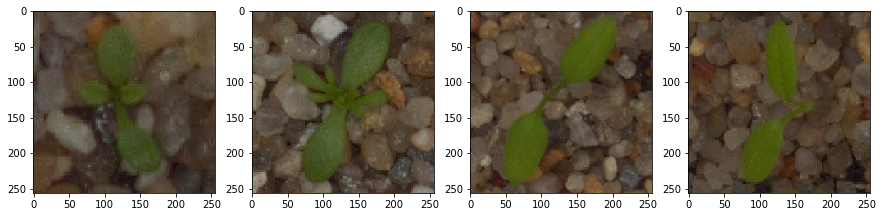

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(15,15))

axs[0].imshow(train_tensors[0])
axs[1].imshow(train_tensors[10])
axs[2].imshow(train_tensors[42])
axs[3].imshow(train_tensors[65])

In [8]:
seed = 31
np.random.seed(seed)



# Split the train and the validation set
train_tensors, val_train, train_targets, val_targets = train_test_split(train_tensors,
                                              train_targets, 
                                              test_size=0.15,
                                              random_state=seed
                                             )

print(train_tensors.shape)
print(val_train.shape)
print(train_targets.shape)
print(val_targets.shape)

(4037, 256, 256, 3)
(713, 256, 256, 3)
(4037, 12)
(713, 12)


In [9]:
model= Sequential()

model.add(Conv2D(filters = 16, kernel_size = (5,5),padding = 'Same', activation ='relu',input_shape=(256,256,3)))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))


model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))


model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.1))

model.add(GlobalAveragePooling2D())

model.add(Dense(256,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(12,activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 16)      1216      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 64, 64, 32)       

In [10]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [11]:
Earlystopping = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1, mode='auto')
history = model.fit(train_tensors, train_targets, epochs = 15, validation_data = (val_train,val_targets))
                    #callbacks=[Earlystopping],batch_size = 64

Train on 4037 samples, validate on 713 samples
Epoch 1/15
4037/4037 [==============================] - 317s 79ms/step - loss: 2.4262 - accuracy: 0.1305 - val_loss: 2.4143 - val_accuracy: 0.1669
Epoch 2/15
4037/4037 [==============================] - 316s 78ms/step - loss: 2.3692 - accuracy: 0.1627 - val_loss: 2.1298 - val_accuracy: 0.2581
Epoch 3/15
4037/4037 [==============================] - 323s 80ms/step - loss: 2.0256 - accuracy: 0.2700 - val_loss: 2.2318 - val_accuracy: 0.2174
Epoch 4/15
4037/4037 [==============================] - 319s 79ms/step - loss: 1.8876 - accuracy: 0.3173 - val_loss: 1.8786 - val_accuracy: 0.2805
Epoch 5/15
4037/4037 [==============================] - 318s 79ms/step - loss: 1.7493 - accuracy: 0.3770 - val_loss: 1.7021 - val_accuracy: 0.3997
Epoch 6/15
4037/4037 [==============================] - 316s 78ms/step - loss: 1.6058 - accuracy: 0.4397 - val_loss: 1.7111 - val_accuracy: 0.3997
Epoch 7/15
4037/4037 [==============================] - 317s 79ms/step 

In [13]:

accuracy=model.evaluate(x=val_train,y=val_targets,batch_size=32)


713/713 [==============================] - 13s 18ms/step


In [15]:
def one_hot_to_dense(labels_one_hot):
    num_labels = labels_one_hot.shape[0]
    num_classes = labels_one_hot.shape[1]
    labels_dense = np.where(labels_one_hot == 1)[1]      
    return labels_dense

In [16]:
validation_predictions = model.predict_classes(val_train)
report=classification_report(one_hot_to_dense(val_targets),validation_predictions)
print(report)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        34
           1       0.86      0.55      0.67        58
           2       0.75      0.66      0.70        50
           3       0.72      0.97      0.82        97
           4       0.75      0.58      0.66        36
           5       0.57      0.68      0.62        69
           6       0.57      0.98      0.72        94
           7       0.88      0.52      0.65        27
           8       0.64      0.68      0.66        72
           9       0.75      0.06      0.12        47
          10       0.62      0.86      0.72        76
          11       0.90      0.51      0.65        53

    accuracy                           0.67       713
   macro avg       0.67      0.59      0.58       713
weighted avg       0.67      0.67      0.63       713



C:\Users\RKRIS\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
species = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize',
           'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
num_species = len(species)
abbreviation = ['BG', 'Ch', 'Cl', 'CC', 'CW', 'FH', 'LSB', 'M', 'SM', 'SP', 'SFC', 'SB']
pd.DataFrame({'class': species, 'abbreviation': abbreviation})

,class,abbreviation
0,Black-grass,BG
1,Charlock,Ch
2,Cleavers,Cl
3,Common Chickweed,CC
4,Common wheat,CW
5,Fat Hen,FH
6,Loose Silky-bent,LSB
7,Maize,M
8,Scentless Mayweed,SM
9,Shepherds Purse,SP


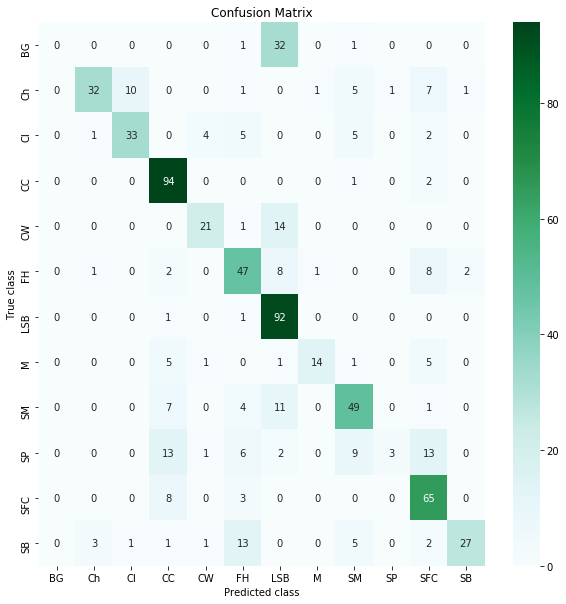

In [18]:
conf_mat= confusion_matrix(one_hot_to_dense(val_targets), validation_predictions)
fig, ax = plt.subplots(1,figsize=(10,10))

ax = sns.heatmap(conf_mat, ax=ax, cmap=plt.cm.BuGn, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
fig.savefig('Confusion matrix.png', dpi=300)
plt.show();

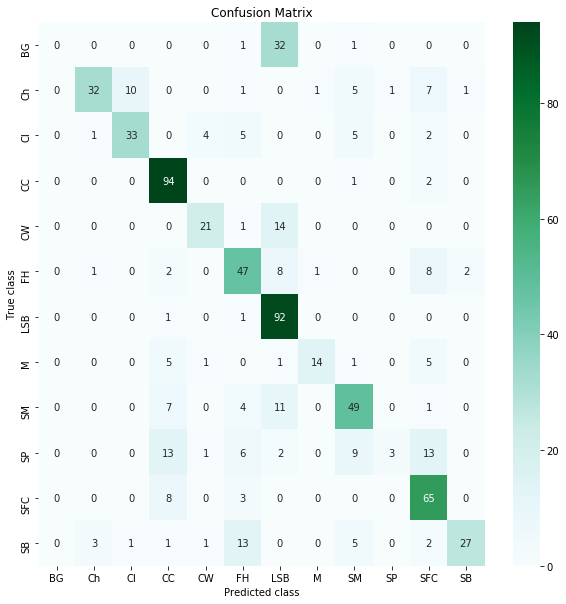

In [19]:

conf_mat= confusion_matrix(one_hot_to_dense(val_targets), validation_predictions)
fig, ax = plt.subplots(1,figsize=(10,10))

ax = sns.heatmap(conf_mat, ax=ax, cmap=plt.cm.BuGn, annot=True)
ax.set_xticklabels(abbreviation)
ax.set_yticklabels(abbreviation)
plt.title('Confusion Matrix')
plt.ylabel('True class')
plt.xlabel('Predicted class')
fig.savefig('Confusion matrix.png', dpi=300)
plt.show();